# Active Learning Workshop: ODSC Bengaluru - Part I
In this course we will run through a series of exercises that will illustrate how to use different variations of active learning. The goal in active learning it to train models that will use less data in a more intelligent way thereby resulting in increased accuracy.

To get started make sure to download and unzip the [data](https://s3-us-west-1.amazonaws.com/figure-eight-dataset/active_learning_odsc_india/Active_Learning_Workshop_data.zip)

In [4]:
import requests 
import pandas as pd
import os 
from os import listdir
from watson_developer_cloud import VisualRecognitionV3
import json
import csv
import random
import time
import zipfile
import matplotlib.pyplot as plt

"""
Variables used for your individual exercise. Make sure to input the correct API KEY,
CLASSIFIER IDS, and DIRECTORIES. These will refer to your project and personal machine
"""
WATSON_API_KEY = '' # INPUT WATSON API KEY
WATSON_CLASSIFIER_ID_1 = "" # INPUT CLASSIFIER 1 ID
WATSON_CLASSIFIER_ID_2 = "" # INPUT CLASSIFIER 2 ID
WATSON_CLASSIFIER_ID_3 = "" # INPUT CLASSIFIER 3 ID
IMAGE_DIRECTORY = '../data/images/' # INPUT PATH TO IMAGE FOLDER
TEST_IMAGES_DIRECTORY = '../data/test_images/' # INPUT PATH TO TEST_IMAGES_DIRECTORY

CLASSES = ['low_quality', 'medium_quality', 'high_quality'] 

visual_recognition = VisualRecognitionV3(
    version='2018-03-19',
    iam_api_key=WATSON_API_KEY 
)


## Initialize Dataframes
The code below will initialize the dataframes that will store the experimental data used through the course. Make sure to only initialize this frame ONCE.

Each dataframe will store the checkpoints made while building the classifier. With these dataframes we will be able to plot the progress of our classifier and see how the accuracy changes over time.

`
Code here
`

In [5]:
classifier_stats = {
    'c0' : [],
    'c1' : [],
    'c2' : [],
    'c3' : [],
}

In [10]:
"""
Helper functions for Active Learning Workshop
"""

"""
function: choose_images(n)
n (int): number of images to get
description: function to select random images from the set of "unlabeled" images
"""
def choose_images(n):
    images = os.listdir(IMAGE_DIRECTORY)
    return random.sample(images, n)

"""
function: run_inferences(images)
images (list): list of names of images that live in the IMAGE_DIRECTORY
directory (constant): TEST_IMAGES_DIRECTORY or IMAGE_DIRECTORY
watson_classifier (constant): WATSON_CLASSIFIER_ID_<number>
description: function to run inferences through Watson on the provided images
"""
def run_inferences(images, directory, watson_classifier):
    results = {}
    print("Running inferences for classifier " + watson_classifier + "...")
    i = 0
    for image in images:
        if i > 10:
            break
        img = open(directory + image, 'rb')
        #print('Running inference for ' + image)
        inference = visual_recognition.classify(
            images_file=img,
            classifier_ids=[watson_classifier],
            threshold=0.0)
        predicted_class = inference['images'][0]['classifiers'][0]['classes'][0]['class']
        confidence = inference['images'][0]['classifiers'][0]['classes'][0]['score']
        results[image] = {'predicted_class':predicted_class, 'confidence':confidence}
        i += 1
    return results

"""
function: label_images_with_ground_truth(images)
images (list): list of names of images that live in the IMAGE_DIRECTORY
description: use the ground truth label to add images into the correct category

return: lists with low, medium, and high quality image sets

**NOTE: Ground truth labels from a crowd can be wrong and will not always provide the optimal data
"""
def label_images_with_ground_truth(images):
    lq = []
    mq = []
    hq = []
    for image in images:
        gt = int(image.split('_')[0])
        if gt < 3:
            lq.append(image)
        elif gt == 3:
            mq.append(image)
        else:
            hq.append(image)
    
    return {'low_quality':lq, 'medium_quality':mq, 'high_quality':hq}

"""
function: compare_with_ground_truth
image: name of image (this has the ground truth)
prediction: predicted class label

return: True if matching, else false
"""
def compare_with_ground_truth(image, prediction):
    gt = int(image.split('_')[0])
    label = ''
    if gt < 3:
        label = 'low_quality'
    elif gt == 3:
        label = 'medium_quality'
    else:
        label = 'high_quality'
    
    if label == prediction:
        return True
    return False

"""
function: create_zip(images, label)
images (list): list of names of images that live in the IMAGE_DIRECTORY
label (str): name of zip file
description: function to create a zip file that will be used to upload to Watson classifier
"""
def create_zip(images, label):
    zip_name = label + '_' + str(int(time.time())) + '.zip'
    z = zipfile.ZipFile(zip_name, 'w')
    for image in images:
        img = open(IMAGE_DIRECTORY + image, 'rb')
        z.write(IMAGE_DIRECTORY + image)
    return zip_name

"""
function: test_accuracy
classifier_name (string): c0, c1, c2, c3
watson_classifier (constant): WATSON_CLASSIFIER_ID_<number>
description: run a test of 100 images and compare with ground truth
        to compute the accuracy of the classifier
"""
def test_classifier(classifier_name, watson_classifier):
    images = os.listdir(TEST_IMAGES_DIRECTORY)
    results = run_inferences(images, TEST_IMAGES_DIRECTORY, watson_classifier)
    comparisons = []
    for image in results:
        prediction = results[image]['predicted_class']
        check = compare_with_ground_truth(image, prediction)
        if check:
            comparisons.append(1)
        else:
            comparisons.append(0)
    correct = sum(comparisons)
    accuracy = correct/len(comparisons)
    print('Accuracy: ' + str(accuracy))
    classifier_stats[classifier_name].append(accuracy)

"""
function plot_confience(inferences)
inferences (dictionary): the output of run_inferences
"""
def plot_confidence(inferences):
    pass


# Exercise 0: Supervised Learning
In the exercise we will use basic supervised learning to update the classifier. This works by selecting a random set of data, labeling that data, and using that to train each class of the classifier.

First, we will test the new classifier that we created. Once we have a baseline accuracy we will use the `supervised_learning()` function to get new batches of data for each class in the form of .zip files which we will use to update each class of the Watson classifier.

Use the function below to automatically select random data, get the labels, and create the zip files required to add to each class of the Watson classifier.

Running inferences for classifier ImageQualityDetector_1749485570...
Accuracy: 0.7272727272727273
Accuracy: 1.0


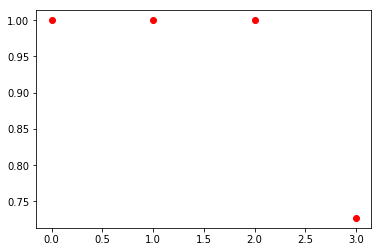

In [11]:
"""
Use this cell to run the preliminary test and calculate the baseline accuracy of the newly created classifer
"""
test_classifier('c0', WATSON_CLASSIFIER_ID_1)
plt.plot(classifier_stats['c0'], 'ro')
plt.show()

Next you will run a series of supervised learning steps. Here you will run the following code to produce class zips and add these to your first classifier. As you complete each round of training, you should run the test code to see how the model accuracy improves over time.

In [165]:
"""
description: function for supervised learning.
Select random images and label all images
"""
def supervised_learning():
    images = choose_images(20)
    labels = label_images_with_ground_truth(images)
    lqz = create_zip(labels['low_quality'], 'low_quality')
    mqz = create_zip(labels['medium_quality'], 'medium_quality')
    hqz = create_zip(labels['high_quality'], 'high_quality')
    print('low quality: ' + lqz)
    print('medium quality: ' + mqz)
    print('high quality: ' + hqz)



#### Task: Run iterations of supervised learning and plot the accuracy of the model as more data is added

In [166]:
# TODO: Write the code to run additional tests after each round of training
# HINT: This is the same code used above to complete the first round of training

# Exercise 1: Confidence Sampling
In this exercise you will use confidence-based sampling. The goal is to create a query method that will rapidly increase the accuracy of your model with as little data as possible.

The idea of confidence sampling is that you are making inferences on your initial classifier. Based on the confidence of these inferences you want to intelligently select which examples you want to add directly to your model and which samples you want to explicitly label.

#### Task: Create a function that uses confidence sampling to select which examples should be manually labeled. Once these have been selected run them through the label function and create batches to be added to the classifier.

#### NOTE: Make sure to run a preliminary test to get a baseline accuracy of your model

In [ ]:
"""
Run preliminary test of classifier to get baseline accuracy
"""
test_classifier('c1', WATSON_CLASSIFIER_ID_2)
plt.plot(classifier_stats['c1'], 'ro')
plt.show()

In [168]:
"""
function: basic_confidence_sampling
threshold (float): float between 0 and 1 for threshold to label images
"""
def confidence_sampling():
    images = choose_images(20) # You can select the number of images you want to test
    inferences = run_inferences(images, IMAGE_DIRECTORY)
    # EXAMPLE CODE:
    """
    for image in inferences:
        to_label = []
        confidence = inferences[image]['confidence']
        if confidence < 0.8:
            to_label.append(image)
    labels = label_images_with_ground_truth(to_label)
    """
    # TODO: fill in your confidence query method here.
    # Based on the confidence select which samples you want to label
    # and then create the required zip files for those images and add them
    # to your model
    
    lqz = create_zip(labels['low_quality'], 'low_quality')
    mqz = create_zip(labels['medium_quality'], 'medium_quality')
    hqz = create_zip(labels['high_quality'], 'high_quality')



In [ ]:
"""
Use this code to test your classifier after each round of confidence sampling and plot your results
"""
test_classifier('c1', WATSON_CLASSIFIER_ID_2)
plt.plot(classifier_stats['c1'], 'ro')
plt.show()

# Exercise 2: Margin Sampling
In this exercise we will use margin sampling to train a third classifier. In margin sampling we want to look at the various predictions provided by the classifier and determine what threshold should be set in order to label the least number of images while getting the most performance gains out of the classifier.

An example of margin sampling could be to manually label any item where the top two predictions are within 20% confidence of one another.

For example:

`
Image 1: {'high_quality': 0.77, 'medium_quality': 0.73, 'low_quality': 0.01}
`

Here we can see that "high_quality" and "medium_quality" are very close and we should get an explicit label to make it apparent which one we should use.

#### NOTE: Make sure to run a preliminary test to get a baseline accuracy of your model

In [ ]:
"""
Run preliminary test of classifier to get baseline accuracy
"""
test_classifier('c2', WATSON_CLASSIFIER_ID_3)
plt.plot(classifier_stats['c2'], 'ro')
plt.show()

In [167]:
def margin_sampling(threshold):
    images = choose_images(20) # You can select the number of images you want to test
    inferences = run_inferences(images, IMAGE_DIRECTORY)
    for image in inferences:
        # TODO: fill in your margin sampling method here
        # Based on the margin of confidence in the resulting predictions
        # you should decide which examples you want to manually label
        # and then create the required zips with those images

In [ ]:
"""
Write your code here to test your classifier after each round of training
This should be WATSON_CLASSIFIER_ID_3 and classifier_stats['c2']
HINT: This is similar to the test and plot code bits used in previous exercises
"""

# Exercise 3: Query by Committee
In this exercise we want to create a query by committee strategy. You have a couple options.

1. Use the three classifiers you trained above as your "committee" and update all classifiers
2. Delete the three classifiers and create three new ones to be used for the query by committee.

Three different intializer datasets are provided so feel free to use those to create your initial classifiers.

#### NOTE: Make sure to run a preliminary test to get a baseline accuracy of your model

In [ ]:
def query_by_committee():
    # TODO: Create a query by committee function.
    # Like before the goal should be to create three zip files in this
    # function that will be the training data to be added to the classifier
    # Also after each round of training we want to run our test to see how
    # the accuracy is improving.

In [ ]:
"""
Write your code here to test your classifier after each round of training
This should be WATSON_CLASSIFIER_ID_3 and classifier_stats['c3']
HINT: This is similar to the test and plot code bits used in previous exercises
"""

# Exercise 4: Build your own
In this exercise you will build your own query function using any of the methods used previous. This is where you should get creative and think about the best query strategy to train a model with the least amount of data.

#### NOTE: Make sure to run a preliminary test to get a baseline accuracy of your model

In [169]:
def my_strategy():
    pass
    # TODO: Fill in your custom query function here

In [170]:
"""
Write your code here to test your classifier after each round of training
HINT: This is similar to the test and plot code bits used in previous exercises
"""

'\nWrite your code here to test your classifier after each round of training\nHINT: This is similar to the test and plot code bits used in previous exercises\n'